# Full Stats, Haccytrees
This notebook will be like a combination of Haccytrees.ipynb and LJ-Full_Fossil_Groups.ipynb. After this one is finished, those notebooks may be cleaned up or deleted

## Set Up

In [1]:
import haccytrees.mergertrees
import h5py
import copy
import numpy as np
import numba
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import pandas as pd
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from itertools import groupby
from matplotlib.ticker import ScalarFormatter
%load_ext line_profiler
%reload_ext autoreload
%autoreload 1
%aimport help_func_haccytrees

plt.rcParams.update({
    "text.usetex": True,
    'font.size': 13,
    "figure.figsize": (5.25, 3.5),#(6.25, 4.25), #(6.25, 3.75)
    "patch.linewidth": 1
})

pyfftw not available, using numpy fft


In [7]:
%%time
with h5py.File("/data/a/cpac/mbuehlmann/LastJourney/forest/z0_catalog.hdf5", "r") as f:
    data = {
        k: d[:] for k, d in f.items()
    }
s = np.argsort(data['tree_node_index'])
data = {k: data[k][s] for k in data.keys()} # all halos at z=0 above a certain mass threshold

CPU times: user 32 s, sys: 19.3 s, total: 51.3 s
Wall time: 51.2 s


In [8]:
%%time
fg_forest_lm5, fg_progenitor_array_lm5 = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest.hdf5",
    'LastJourney',
    mass_threshold=5e11
)

CPU times: user 25.6 s, sys: 34.9 s, total: 1min
Wall time: 1min


#### What is `data`?
`data` is a dictionary containing only the halo information we are interested in (i.e. just at $z=0$). Use `data.keys()` to see what's inside. You can treat `data` largely like you treated `forest`: i.e. to get a `key` for a specific subset of halos, use `data['key_name'][halo_idx]`.
On the fossil groups side, the equivalent of `data` is `fg_catalog`, which consists only of $z=0$ information for halos we have previously identified as fossil groups. We create `fg_catalog` from `fg_forest.hdf5` below.

In [9]:
data.keys()

dict_keys(['delta+1_rsoft0.0', 'delta+1_rsoft1.0', 'delta+1_rsoft10.0', 'delta+1_rsoft2.0', 'delta+1_rsoft4.0', 'filenum', 'index', 'sig_rsoft_0.0', 'sig_rsoft_1.0', 'sig_rsoft_10.0', 'sig_rsoft_2.0', 'sig_rsoft_4.0', 'sod_halo_cdelta', 'sod_halo_cdelta_accum', 'sod_halo_cdelta_peak', 'tree_node_index', 'tree_node_mass', 'x', 'xoff_com', 'xoff_fof', 'xoff_sod', 'y', 'z'])

In [10]:
%%time
mask_z0 = fg_forest_lm5['snapnum'] == 100
fg_catalog_lm5 = {k: fg_forest_lm5[k][mask_z0] for k in fg_forest_lm5.keys()} # forest data at z=0 # Why is this different from `assign_fgs()`?
s = np.argsort(fg_catalog_lm5['tree_node_index']) # How is this being sorted exactly?
fg_catalog_lm5 = {k: fg_catalog_lm5[k][s] for k in fg_catalog_lm5.keys()}

CPU times: user 2.33 s, sys: 102 ms, total: 2.43 s
Wall time: 2.43 s


In [ ]:
%%time
fg_forest_lm3, fg_progenitor_array_lm3 = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_lm3e11.hdf5",
    'LastJourney',
    mass_threshold=3e11
)

fg_forest_lm15, fg_progenitor_array_lm15 = haccytrees.mergertrees.read_forest(
    "/data/a/cpac/mbuehlmann/LastJourney/forest/fg_forest_lm1.5e11.hdf5",
    'LastJourney',
    mass_threshold=1.5*10**11
)

mask_z0 = fg_forest_lm3['snapnum'] == 100
fg_catalog_lm3 = {k: fg_forest_lm3[k][mask_z0] for k in fg_forest_lm3.keys()} # forest data at z=0
s = np.argsort(fg_catalog_lm3['tree_node_index']) # Why do we need this sorting?
fg_catalog_lm3 = {k: fg_catalog_lm3[k][s] for k in fg_catalog_lm3.keys()}

mask_z0 = fg_forest_lm15['snapnum'] == 100
fg_catalog_lm15 = {k: fg_forest_lm15[k][mask_z0] for k in fg_forest_lm15.keys()} # forest data at z=0
s = np.argsort(fg_catalog_lm15['tree_node_index']) # Why do we need this sorting?
fg_catalog_lm15 = {k: fg_catalog_lm15[k][s] for k in fg_catalog_lm15.keys()}

In [7]:
print(len(fg_catalog['tree_node_mass'][(fg_catalog['tree_node_mass'] > 10**13) & (fg_catalog['tree_node_mass'] < 10**14)]))

953215


In [6]:
print(fg_catalog_lm5.keys())

dict_keys(['branch_size', 'desc_node_index', 'fof_halo_center_x', 'fof_halo_center_y', 'fof_halo_center_z', 'fof_halo_count', 'fof_halo_mass', 'fof_halo_tag', 'snapnum', 'sod_halo_cdelta', 'sod_halo_cdelta_accum', 'sod_halo_cdelta_error', 'sod_halo_cdelta_peak', 'sod_halo_count', 'sod_halo_mass', 'sod_halo_radius', 'tree_node_index', 'tree_node_mass', 'xoff_com', 'xoff_fof', 'xoff_sod', 'scale_factor', 'descendant_idx', 'progenitor_count', 'progenitor_offset', 'halo_index'])


### Mass Matching/Narrow Bins

In [11]:
halo_masks = help_func_haccytrees.make_masks(data, pre_masked_z0 = True)
fg_masks_lm5 = help_func_haccytrees.make_masks(fg_forest_lm5)
#print(fg_masks_lm5[0][0:100])
#fg_masks_lm51 = help_func_haccytrees.make_masks(fg_catalog_lm5, pre_masked_z0 = True) # previously this was forest? Will that be a problem? # I think catalog is just a forest at z = 0
#print(fg_masks_lm51[0][0:100])
#fg_masks_lm3 = help_func_haccytrees.make_masks(fg_catalog_lm3, pre_masked_z0 = True)
#fg_masks_lm15 = help_func_haccytrees.make_masks(fg_catalog_lm15, pre_masked_z0 = True)

### Go find some QHs

In [18]:
qh_masks = []
for this_mask in (fg_masks_lm5):
    fg_idx = np.nonzero(this_mask)[0]
    mainbranch_index, mainbranch_masses = help_func_haccytrees.get_branches(fg_idx, fg_forest_lm5)
    mainbranch_mergers = help_func_haccytrees.get_mainbranch_mergers(fg_forest_lm5, fg_progenitor_array_lm5, mainbranch_index)
    major_mergers = help_func_haccytrees.get_major_mergers(mainbranch_mergers)
    lmm_redshift = help_func_haccytrees.get_lmms(major_mergers)
    fgs, qhs, mrich = help_func_haccytrees.find_specials(fg_forest_lm5, mainbranch_index, major_mergers, lmm_redshift, fg_idx)
    # This qhs index will be an index associated with this specific mass bin/this fg mask. Is there any reason to have a mask version? Maybe, because of later...
    #print(len(qhs))
    #print(qhs)
    qh_mask = np.zeros_like(this_mask)
    qh_mask[qhs] = 1
    print(qh_mask.shape)
    #print(np.nonzero(qh_mask)[0])
    print(len(np.nonzero(qh_mask[qhs])[0])) # Why is this length slightly smaller than len(qhs)? (by 4, which is weird)
    print(len(qh_mask))
    qh_masks.append(qh_mask)
    # Why would this be different from
    # qh_mask = copy.deepcopy(this_mask)
    # qh_mask[~qhs] = False
#print(qh_masks)

(92193207,)
30077
92193207
(92193207,)
294
92193207
(92193207,)
0
92193207


# Concentration vs. Relaxation

### Helper Functions (thanks Michael!)

In [55]:
def contour_level(data, levels): # data = probs
    # Get levels from percentages
    data_sum = np.sum(data)
    levels = levels*data_sum
    
    data_flat = np.sort(data.flatten())[::-1]
    data_cm = np.cumsum(data_flat)
    assert data_cm[-1] <= 1
    contour_level = np.empty(len(levels))
    
    # We want percentages, not specific numbers?
    for i, l in enumerate(levels):
        try:
            #print("data_cm ", data_cm, " vs. l ", l, " <=? ", data_cm <= l, "\ncorresponding data: ", data_flat[data_cm <= l])
            contour_level[i] = data_flat[data_cm <= l][-1]
        except:
            contour_level[i] = data_flat[0]  # If there is no element with data_cm <= l
    return np.sort(contour_level)  # sort, because contour plot requires levels in ascending order

def get_stats(data_x, data_y, bins_x, bins_y, levels, smooth=0):
    # create histogram
    probs, xedges, yedges = np.histogram2d(data_x, data_y, [bins_x, bins_y], density=False)# density=True)
    # normalize (i.e. a density)
    probs = probs / len(data_x)
    #probs /= len(data_x)
    # smooth if requested
    if smooth > 0:
        probs = scipy.ndimage.gaussian_filter(probs, smooth)
    #print(probs)
    #print(levels)
    contour_levels = contour_level(probs, levels)
    # 1d histograms
    x_hist, _ = np.histogram(data_x, bins_x, density=True)
    y_hist, _ = np.histogram(data_y, bins_y, density=True)
    if smooth > 0:
        x_hist = scipy.ndimage.gaussian_filter(x_hist, smooth/2)
        y_hist = scipy.ndimage.gaussian_filter(y_hist, smooth/2)
    return probs, contour_levels, x_hist, y_hist

### All mass bins in one plot

In [56]:
print(len(fg_forest_lm5['sod_halo_cdelta']))

92193207


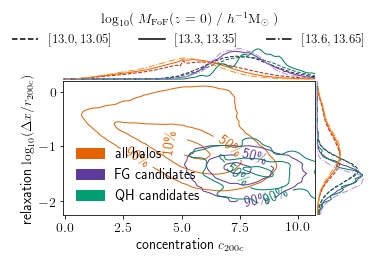

In [74]:
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (5.4, 3.25), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

# create figure and axes (you'll need to import matplotlib.gridspec)
import matplotlib.gridspec
smooth_lengths = [0.75, 1, 2.5]
bin_labels = [r"$[13.0, 13.05]$", r"$[13.3, 13.35]$", r"$[13.6, 13.65]$"]
fig = plt.figure() #6.25, 3.75
gs = matplotlib.gridspec.GridSpec(2, 2, hspace=0, wspace=0, height_ratios=[1, 4], width_ratios=[5, 1])
ax = plt.subplot(gs[1,0])
ax_x = plt.subplot(gs[0, 0])
ax_y = plt.subplot(gs[1, 1])
oranges = ["#CC2200", "#E66100", "#FF8C1A"] # "#E67A00", "#CC3300"
purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"] # "#9345BA", "#4B235D"
greens = ["#00755F", "#00805D", "#009E73", "#00E6A7"]
linestyles_for_bins = ['--', '-', '-.']
levels = np.array([0.9, 0.5, 0.1])
level_labels = ["90\%", "50\%", "10\%"]
class_labels = ["all halos", "FG candidates", "QH candidates"] # Is this better than putting it inside?

# Loop over mass bins
for massbin_n in [0,1,2]:
    this_bin_linestyle = linestyles_for_bins[massbin_n]
    colors = [oranges[massbin_n], purples[massbin_n], greens[massbin_n]]
    smooth = smooth_lengths[massbin_n]
    
    # Loop over halo classes
    for i, (catalog, this_halo_mask) in enumerate(zip([data, fg_forest_lm5, fg_forest_lm5], [halo_masks[massbin_n], fg_masks_lm5[massbin_n], qh_masks[massbin_n]])):
        #print(i)
        if i == 2:
            smooth = 2.5
            if massbin_n == 2:
                break
        data_x = catalog['sod_halo_cdelta'][this_halo_mask] # Not always a mask, sometimes an index
        data_y = np.log10(catalog['xoff_fof'][this_halo_mask])
        if i == 0: # Use the same bins for both classes
            bins_x = np.linspace(np.mean(data_x) - 3*np.std(data_x), np.mean(data_x) + 3.5*np.std(data_x), 100) # Why is this cutting in half? # np.mean(data_x) + np.std(data_x)
            bins_y = np.linspace(np.mean(data_y) - 3*np.std(data_y), np.mean(data_y) + 3*np.std(data_y), 100) # Was 14 and 1
        
        # calculate data
        probs, contour_levels, x_hist, y_hist = get_stats(data_x, data_y, bins_x, bins_y, levels, smooth) # Should I smooth?
        centers_x = (bins_x[:-1] + bins_x[1:])/2 # When should "x"/"y" go first, and when should they go at the end? (when naming things)
        centers_y = (bins_y[:-1] + bins_y[1:])/2 # Use bins, not hists (hists are just the x and y data)

        # plot 1D histograms
        ax_x.plot(centers_x, x_hist, color=colors[i], linestyle = this_bin_linestyle, linewidth = 1) # Cute little side plots :) 
        ax_y.plot(y_hist, centers_y, color=colors[i], linestyle = this_bin_linestyle, linewidth = 1)

        # plot contours only for the middle bin
        if massbin_n == 1:
            fmt = {contour_levels[0]: "90\%", contour_levels[1]: "50\%", contour_levels[2]: "10\%"}
            CS = ax.contour(centers_x, centers_y, probs.T, contour_levels, colors=colors[i], linewidths = 1)
            ax.clabel(CS, inline=1, fmt = fmt) # fontsize=14, 
            
# Legends
fossil_status_handles = [mpatches.Patch(color = color, label = label) for color, label in zip(["#E66100", "#5D3A9B", "#009E73"], class_labels)]
leg1 = ax.legend(handles = fossil_status_handles, loc = "lower left", frameon = False)
massbin_handles = [ax.plot([], [], linestyle = linestyle, color = "black")[0] for linestyle in linestyles_for_bins]
leg2 = ax.legend(massbin_handles, bin_labels, loc='upper center', frameon = False, ncol = 3, bbox_to_anchor=(0.5, 1.6), title = r"$\log_{10}(\; M_\mathrm{FoF}(z=0) \; / \; h^{-1} \mathrm{M}_\odot \;)$", fontsize = 13)
ax.add_artist(leg1)

# Cosmetics
# ylim=bins_y[[0,-1]] 
# ylim=(-2.25, 0.2) 
ax.set(xlim=bins_x[[0,-1]], ylim=(-2.25, 0.2), xlabel=r'concentration $c_{200c}$', ylabel=r'relaxation $\log_{10}(\Delta x / r_{200c})$')
ax_x.set(xlim=bins_x[[0,-1]], xticklabels=[])
ax_x.axis('off')
ax_y.axis('off')
ax_y.set(ylim=bins_y[[0,-1]], yticklabels=[])
plt.tight_layout()
fig.savefig("full_lj_plots/cdelta_log-xoff_contour_all_massbins_qhs.png", bbox_inches='tight', pad_inches=0)

## Concentrations

all halos 13.0 to 13.05 :  1919589
fossil groups 13.0 to 13.05 :  269358
all halos 13.3 to 13.35 :  975970
fossil groups 13.3 to 13.35 :  36181
all halos 13.6 to 13.65 :  474295
fossil groups 13.6 to 13.65 :  2454


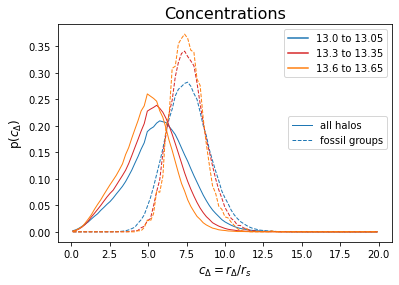

In [9]:
# Repeat for multiple bins
fig, ax = plt.subplots()
linewidth = 1
nbins = 100
colors = iter(['tab:blue', 'tab:red', 'tab:orange'])
bin_labels = []
fake_lines = []
for i, bins in enumerate([mbin_thin_13_0, mbin_thin_13_3, mbin_thin_13_6]): # is there another way to do this
    current_color = next(colors)
    bin_labels.append(str(np.log10(bins[0])) + " to " + str(np.log10(bins[1]))) # Kinda lame to have to do it this way...
    labels = iter(["all halos", "fossil groups"])
    linestyles = iter(['-', '--'])
    for catalog in [data, fg_catalog]:
        current_label = next(labels)
        current_linestyle = next(linestyles)
        bin_mask = (catalog['tree_node_mass'] > bins[0]) & (catalog['tree_node_mass'] < bins[1])
        cdeltas = catalog['sod_halo_cdelta'][bin_mask]
        print(current_label, bin_labels[i], ": ", len(cdeltas))
        c_mask = cdeltas > 0 # I'm assuming those -1 values shouldn't be there either?
        cdeltas = cdeltas[c_mask]
        hist = np.histogram(cdeltas, bins = np.linspace(0, 20, nbins), density = True) # np.min(cdeltas)
        bin_centers = (hist[1][:-1] + hist[1][1:]) / 2
        ax.plot(bin_centers, hist[0], label = current_label, linestyle = current_linestyle, color = current_color, linewidth = linewidth)
        if i == 0:
            legend1 = ax.legend(loc = "center right")
    fake_lines.append(ax.plot([],[], c = current_color)[0])

# Cosmetics
leg2 = ax.legend(fake_lines,bin_labels, loc='upper right')
ax.add_artist(legend1)
ax.set_xlabel(r"$c_\Delta = r_\Delta/r_s$", fontsize = 12)
ax.set_ylabel(r"p($c_\Delta$)", fontsize = 12)
ax.set_title("Concentrations", fontsize = 16)
fig.savefig("full_lj_plots/cdeltas_narrow_bins.png")

#### Relaxation Matching

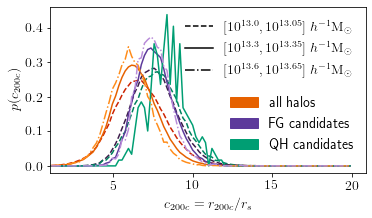

In [64]:
# Now check those relaxations
plt.rcParams.update({
    'font.size': 14,
    "figure.figsize": (5.4, 3.25), #(5.2, 3.13), #(5.4, 3.25), #(5.83, 3.5),#(6.25, 4.25), #(6.25, 3.75)
})

fig, ax = plt.subplots()
nbins = 100
#colors = ["#5D3A9B", "#E66100"] # "#009E73"
#color_labels = ["all halos", "fossil candidates"]
linestyles = ['--', '-', '-.']
bin_labels = [r"$[10^{13.0}, 10^{13.05}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.3}, 10^{13.35}]$ $h^{-1}\mathrm{M}_\odot$", r"$[10^{13.6}, 10^{13.65}]$ $h^{-1}\mathrm{M}_\odot$"]
#bin_labels = [r"$[10^{13.0}, 10^{13.05}]$", r"$[10^{13.3}, 10^{13.35}]$", r"$[10^{13.6}, 10^{13.65}]$"]
fake_lines = []
oranges = ["#CC2200", "#E66100", "#FF8C1A"]
purples = ["#3C1C4A", "#5D3A9B", "#B98CD9"]
greens = ["#00805D", "#009E73", "#00E6A7"]
for i, (this_halo_mask, this_fg_mask, this_qh_mask) in enumerate(zip(halo_masks, fg_masks_lm5, qh_masks)): # is there another way to do this?
    current_linestyle = linestyles[i]
    
    xoff_matching_mask = help_func_haccytrees.match_catalogs_by_key(data, fg_forest_lm5, key = 'xoff_fof', data_mask = this_halo_mask, fg_mask = this_fg_mask) 
    halo_cdeltas = data['sod_halo_cdelta'][this_halo_mask][xoff_matching_mask]
    fg_cdeltas = fg_forest_lm5['sod_halo_cdelta'][this_fg_mask]
    qh_cdeltas = fg_forest_lm5['sod_halo_cdelta'][this_qh_mask]
    
    color_labels = iter(["all halos", "FG candidates", "QH candidates"])
    colors = iter([oranges[i], purples[i], greens[i]])
    #colors = iter(["#5D3A9B", "#E66100"])
    fossil_status_legend_handles = []
    for j, these_cdeltas in enumerate([halo_cdeltas, fg_cdeltas, qh_cdeltas]):
        if i == 2 and j == 2:
            break
        current_label = next(color_labels)
        current_color = next(colors)
        
        these_cdeltas = these_cdeltas[these_cdeltas > 0] # is this necessary anymore?
        hist = np.histogram(these_cdeltas, bins = np.linspace(0, 20, nbins), density = True)
        bin_centers = (hist[1][:-1] + hist[1][1:]) / 2
        ax.plot(bin_centers, hist[0], label = current_label, color = current_color, linestyle = current_linestyle)
        fossil_status_legend_handles.append(mpatches.Patch(color = current_color, label = current_label))
                        
    # Legend for fossil status
    if i == 1:
        legend1 = ax.legend(handles = fossil_status_legend_handles, frameon = False, loc = "center right", bbox_to_anchor = (1, 0.3)) # loc = "lower right",
        #legend1 = ax.legend(loc = "center right")

    # Legend for mass bins
    fake_lines.append(ax.plot([],[], c = 'k', linestyle = current_linestyle)[0])
    #bin_legend_handles.append(mpatches.Patch(color = current_color, label = color_labels[j]))

# Cosmetics
legend2 = ax.legend(fake_lines, bin_labels, loc='upper right', frameon = False)#, fontsize = 14) # title =  r"mass bin $[h^{-1}\mathrm{M}_\odot]$"
ax.add_artist(legend1)
ax.set_xlabel(r"$c_{200c} = r_{200c}/r_s$")
ax.set_ylabel(r"$p(c_{200c})$")
ax.set_xlim(left = 1)
#ax.set_title("Concentrations: xoff corrected", fontsize = 16)
plt.tight_layout()
fig.savefig("full_lj_plots/cdeltas_relaxation_corrected_qhs.png", bbox_inches='tight', pad_inches=0)

### Concentration matching: narrow bins

In [49]:
# Make masks
#fgs_idx = fg_catalog['halo_index'] # Leave to what you assigned above

cbin_data_thin_3 = [2.75, 3]
cbin_data_thin_5 = [5, 5.25]
cbin_data_thin_7 = [7, 7.25]

cbin_fg_thin_6 = [6, 6.25]
cbin_fg_thin_7 = [7.5, 7.75]
cbin_fg_thin_9 = [8.75, 9]

cbin_all_thin_4 = [4, 4.25]
cbin_all_thin_6 = [6, 6.25]
cbin_all_thin_8 = [8, 8.25]

mlim = [1e13, 1e14]
halo_target_idx = np.nonzero(make_masks(data, bins = [mlim])[0])[0] # is this "unpythonic"? (i.e. too complicated for one line?)

def make_cmasks(my_forest, bins = [cbin_data_thin_3, cbin_data_thin_5, cbin_data_thin_7], target_idx = None):
    masks = []
    for this_bin in bins:
        if target_idx is None:
            thin_mask = (my_forest['sod_halo_cdelta'] > this_bin[0]) & (my_forest['sod_halo_cdelta'] < this_bin[1]) # Notice fg_forest here
            #mask = np.logical_and(mask_z0, thin_mask)
            masks.append(thin_mask)
        else:
            thin_mask = (my_forest['sod_halo_cdelta'][target_idx] > this_bin[0]) & (my_forest['sod_halo_cdelta'][target_idx] < this_bin[1])
            #mask = np.logical_and(mask_z0[target_idx], thin_mask) # could I just do mask_z0[target_idx here?]
            masks.append(thin_mask)
    return masks

halo_cmasks = make_cmasks(data, bins = [cbin_data_thin_3, cbin_data_thin_5, cbin_data_thin_7], target_idx = target_idx)
fg_cmasks = make_cmasks(fg_catalog, bins = [cbin_fg_thin_6, cbin_fg_thin_7, cbin_fg_thin_9]) # I guess these were already in the correct mass range?
halo_all_cmasks = make_cmasks(data, bins = [cbin_all_thin_4, cbin_all_thin_6, cbin_all_thin_8], target_idx = target_idx)
fg_all_cmasks = make_cmasks(fg_catalog, bins = [cbin_all_thin_4, cbin_all_thin_6, cbin_all_thin_8])

for these_cmasks in [halo_cmasks, halo_all_cmasks, fg_cmasks, fg_all_cmasks]:
    print("next")
    for i in range(3):
        print(np.nonzero(these_cmasks[i])[0])
        print(len(np.nonzero(these_cmasks[i])[0]))

next
[      75       76       82 ... 15825628 15825653 15825662]
340886
[       5        9       19 ... 15825638 15825644 15825652]
825389
[      10       37       42 ... 15825548 15825556 15825598]
525985
next
[      50       83       92 ... 15825573 15825614 15825659]
626788
[      12       33       36 ... 15825538 15825580 15825630]
823391
[      74      110      111 ... 15824950 15824974 15825392]
250048
next
[    86    193    210 ... 953199 953206 953207]
42544
[     6     15     31 ... 953128 953182 953184]
72239
[     4     29     87 ... 953157 953162 953169]
40264
next
[   407    538    609 ... 951003 951267 953170]
1333
[    86    193    210 ... 953199 953206 953207]
42544
[    17     26     35 ... 953113 953117 953172]
63347


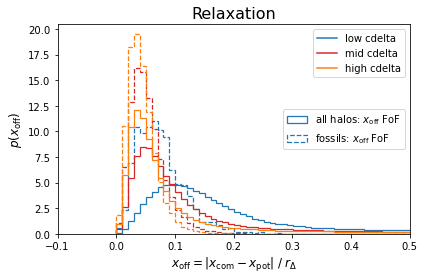

In [50]:
# Now check those relaxations
fig, ax = plt.subplots()
linewidth = 1.25
colors = iter(['tab:blue', 'tab:red', 'tab:orange'])
bin_labels = ['low cdelta', 'mid cdelta', 'high cdelta']
fake_lines = []
for i, (this_fg_cmask, this_halo_cmask) in enumerate(zip(fg_all_cmasks, halo_all_cmasks)): # is there another way to do this
    current_color = next(colors)
    
    ax.hist(data['xoff_fof'][halo_target_idx][this_halo_cmask], np.linspace(0, 2, 200), histtype='step', density=True, linestyle = '-', label="all halos: " + r'$x_\mathrm{off}$ FoF', color = current_color, linewidth = linewidth); #color=cmap[0],
    ax.hist(fg_catalog['xoff_fof'][this_fg_cmask], np.linspace(0, 2, 200), histtype='step', density=True, linestyle='--', label="fossils: " + r'$x_\mathrm{off}$ FoF', color = current_color, linewidth = linewidth); # color=cmap[0],
    if i == 0:
        legend1 = ax.legend(loc = "center right")
    fake_lines.append(ax.plot([],[], c = current_color)[0])

# Legend
leg2 = ax.legend(fake_lines, bin_labels, loc='upper right')
ax.add_artist(legend1)

# Cosmetics
ax.set_xlabel(r"$x_\mathrm{off} = \left| x_\mathrm{com} - x_\mathrm{pot} \right| \; / \; r_\Delta$", fontsize = 12)
ax.set_ylabel(r'$p(x_\mathrm{off})$', fontsize = 12)
ax.set_xlim([-0.1,0.5])
ax.set_title("Relaxation", fontsize = 16)
fig.tight_layout()
fig.savefig("full_lj_plots/relaxations_cdelta_corrected_same_bins.png")

In [29]:
# Anyway, let's get a narrow mass bin, then match the concentrations

my_fg_mask = fg_masks[0]
my_halo_mask = halo_masks[0]
cdelta_matching_mask = help_func_haccytrees.match_cdeltas_catalog(data, fg_catalog, key = 'sod_halo_cdelta', data_mask = my_halo_mask, fg_mask = my_fg_mask) # for
print(cdelta_matching_mask)
print(data['sod_halo_cdelta'][my_halo_mask][cdelta_matching_mask])


pyfftw not available, using numpy fft


/data/a/cpac/aurora/fossil_groups/help_func_haccytrees.py:901: RuntimeWarning: invalid value encountered in true_divide
  # Selection probabilities


[False False False ... False False False]
[9.654022 7.567972 5.92795  ... 8.478727 8.721155 5.108097]


/data/a/cpac/aurora/fossil_groups/help_func_haccytrees.py:901: RuntimeWarning: invalid value encountered in true_divide
  # Selection probabilities
/data/a/cpac/aurora/fossil_groups/help_func_haccytrees.py:901: RuntimeWarning: invalid value encountered in true_divide
  # Selection probabilities
/data/a/cpac/aurora/fossil_groups/help_func_haccytrees.py:901: RuntimeWarning: invalid value encountered in true_divide
  # Selection probabilities


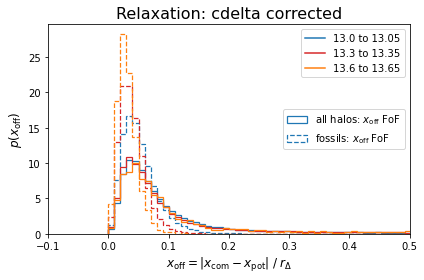

In [50]:
# Now check those relaxations
fig, ax = plt.subplots()
linewidth = 1.25
colors = iter(['tab:blue', 'tab:red', 'tab:orange'])
bin_labels = ['13.0 to 13.05', '13.3 to 13.35', '13.6 to 13.65']
fake_lines = []
for i, (this_fg_mask, this_halo_mask) in enumerate(zip(fg_masks, halo_masks)): # is there another way to do this
    current_color = next(colors)
    
    cdelta_matching_mask = help_func_haccytrees.match_catalogs_by_key(data, fg_catalog, key = 'sod_halo_cdelta', data_mask = this_halo_mask, fg_mask = this_fg_mask) 
    ax.hist(data['xoff_fof'][this_halo_mask][cdelta_matching_mask], np.linspace(0, 2, 200), histtype='step', density=True, linestyle = '-', label="all halos: " + r'$x_\mathrm{off}$ FoF', color = current_color, linewidth = linewidth); #color=cmap[0],
    ax.hist(fg_catalog['xoff_fof'][this_fg_mask], np.linspace(0, 2, 200), histtype='step', density=True, linestyle='--', label="fossils: " + r'$x_\mathrm{off}$ FoF', color = current_color, linewidth = linewidth); # color=cmap[0],
    if i == 0:
        legend1 = ax.legend(loc = "center right")
    fake_lines.append(ax.plot([],[], c = current_color)[0])

# Legend
leg2 = ax.legend(fake_lines, bin_labels, loc='upper right')
ax.add_artist(legend1)

# Cosmetics
ax.set_xlabel(r"$x_\mathrm{off} = \left| x_\mathrm{com} - x_\mathrm{pot} \right| \; / \; r_\Delta$", fontsize = 12)
ax.set_ylabel(r'$p(x_\mathrm{off})$', fontsize = 12)
ax.set_xlim([-0.1,0.5])
ax.set_title("Relaxation: cdelta corrected", fontsize = 16)
fig.tight_layout()
fig.savefig("full_lj_plots/relaxations_cdelta_corrected_narrow_mass_bins.png")

### Michael's approach, matching relaxation distributions (between FGs and random sample)

In [ ]:
import matplotlib.gridspec
smooth_lengths = [0.75, 1, 3]
bin_labels = ["13 to 13.05", "13.3 to 13.35", "13.6 to 13.65"]
for massbin_n in [0,1,2]:
    fig = plt.figure(figsize=(9, 5.3))
    gs = matplotlib.gridspec.GridSpec(2, 2, hspace=0, wspace=0, height_ratios=[1, 4], width_ratios=[5, 1])
    ax = plt.subplot(gs[1,0])
    ax_x = plt.subplot(gs[0, 0])
    ax_y = plt.subplot(gs[1, 1])

    levels = np.array([0.9, 0.5, 0.1])
    smooth = smooth_lengths[massbin_n]
    linestyles = ['dotted', 'dashed', 'solid']
    colors = ['tab:blue', 'tab:red']
    labels = ['Random Sample', 'Fossil Group']
    
    relaxation_mask = help_func_haccytrees.match_catalogs_by_key(data, fg_catalog, key = 'xoff_fof', data_mask = halo_masks[massbin_n], fg_mask = fg_masks[massbin_n])
    #for i, (catalog, this_halo_mask) in enumerate(zip([data, fg_catalog], [halo_masks[massbin_n][relaxation_mask], fg_masks[massbin_n]])):
    for i, (catalog, this_halo_mask) in enumerate(zip([data, fg_catalog], [halo_masks[massbin_n], fg_masks[massbin_n]])):
        if i == 0: # What is even the point anymore
            data_x = catalog['sod_halo_cdelta'][this_halo_mask][relaxation_mask]
            data_y = np.log10(catalog['xoff_fof'][this_halo_mask][relaxation_mask])
            bins_x = np.linspace(np.mean(data_x) - 3*np.std(data_x), np.mean(data_x) + 3*np.std(data_x), 100) # Why is this cutting in half? # np.mean(data_x) + np.std(data_x)
            bins_y = np.linspace(np.mean(data_y) - 3*np.std(data_y), np.mean(data_y) + 3*np.std(data_y), 100) # Was 14 and 1
        else:
            data_x = catalog['sod_halo_cdelta'][this_halo_mask]
            data_y = np.log10(catalog['xoff_fof'][this_halo_mask])
            
        # calculate data
        probs, contour_levels, x_hist, y_hist = get_stats(data_x, data_y, bins_x, bins_y, levels, smooth) # Should I smooth?
        centers_x = (bins_x[:-1] + bins_x[1:])/2 # When should "x"/"y" go first, and when should they go at the end? (when naming things)
        centers_y = (bins_y[:-1] + bins_y[1:])/2 # Use bins, not hists (hists are just the x and y data)

        # plot data
        ax.contour(centers_x, centers_y, probs.T, contour_levels, colors=colors[i], linestyles=linestyles)
        ax.plot([], [], color=colors[i], label=labels[i])
        ax_x.plot(centers_x, x_hist, color=colors[i]) # Cute little side plots :)
        ax_y.plot(y_hist, centers_y, color=colors[i])

    fake_lines = [ax.plot([], [], linestyle = linestyle, color = "black", label = str(level*100) + "%")[0] for linestyle, level in zip(linestyles, levels)]

    ax.set(xlim=bins_x[[0,-1]], ylim=bins_y[[0,-1]], xlabel=r'concentration $c_{200c}$', ylabel=r'relaxation log($x_\mathrm{off}$)')
    ax_x.set(xlim=bins_x[[0,-1]], xticklabels=[])
    ax_x.axis('off')
    ax_y.axis('off')
    ax_y.set(ylim=bins_y[[0,-1]], yticklabels=[])
    #ax_p.axis('off')
    #ax.set_title("mass bin: " + bin_labels[massbin_n] + ", smoothing: " + str(smooth), y=1.35, pad=-14) # 1.0, -14
    ax.set_title("mass bin: " + bin_labels[massbin_n], y=1.35, pad=-14)
    ax.legend(frameon=False)
    #fig.savefig("full_lj_plots/cdelta_log-xoff_contour_smooth" + str(smooth) + "_massbin" + str(massbin_n) + "_relaxation_matched.png")

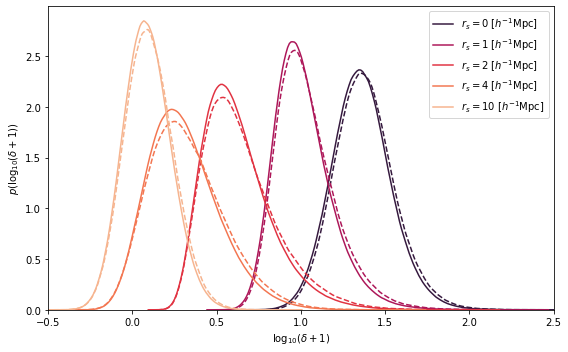

In [99]:
# From Michael
fig, ax = plt.subplots(figsize=(8, 5))
cmap = sns.color_palette("rocket")
sns.kdeplot(np.log10(data['delta+1_rsoft0.0'][mask]), color=cmap[0], common_norm=False, fill=False, label=r'$r_s = 0$ [$h^{-1}$Mpc]');
sns.kdeplot(np.log10(data['delta+1_rsoft0.0'][fg_index])  , color=cmap[0], common_norm=False, fill=False, linestyle='dashed');
sns.kdeplot(np.log10(data['delta+1_rsoft1.0'][mask]), color=cmap[2], common_norm=False, fill=False, label=r'$r_s = 1$ [$h^{-1}$Mpc]');
sns.kdeplot(np.log10(data['delta+1_rsoft1.0'][fg_index])  , color=cmap[2], common_norm=False, fill=False, linestyle='dashed');
sns.kdeplot(np.log10(data['delta+1_rsoft2.0'][mask]), color=cmap[3], common_norm=False, fill=False, label=r'$r_s = 2$ [$h^{-1}$Mpc]');
sns.kdeplot(np.log10(data['delta+1_rsoft2.0'][fg_index])  , color=cmap[3], common_norm=False, fill=False, linestyle='dashed');
sns.kdeplot(np.log10(data['delta+1_rsoft4.0'][mask]), color=cmap[4], common_norm=False, fill=False, label=r'$r_s = 4$ [$h^{-1}$Mpc]');
sns.kdeplot(np.log10(data['delta+1_rsoft4.0'][fg_index])  , color=cmap[4], common_norm=False, fill=False, linestyle='dashed');
sns.kdeplot(np.log10(data['delta+1_rsoft10.0'][mask]),color=cmap[5], common_norm=False, fill=False, label=r'$r_s = 10$ [$h^{-1}$Mpc]');
sns.kdeplot(np.log10(data['delta+1_rsoft10.0'][fg_index])  ,color=cmap[5], common_norm=False, fill=False, linestyle='dashed');
ax.set(xlabel=r'$\log_{10}(\delta+1)$', xlim=[-0.5, 2.5], ylabel=r'$p(\log_{10}(\delta+1))$')
ax.legend()
fig.tight_layout()